# Predicting the duration of CI pipelines with Machine Learning

Our customers would love to know how long their CI pipeline takes. Ideally, we would want to build a model that can account for the current state of Helix, the workitems they send, the congestion of AzDo, etc. to get a decent accurate. Unfortunately, this is a highly complex model that is quite difficult to build (but theoretically possible).

Instead, we can build a model to give us a range of estimates, based on the past durations of their pipelines.

Thanks to our data, we have tons of historical data that can enable us to make predictions and generate confidence intervals on the length of CI pipelines.

## Stakeholders

* Our Partners (@dncpartners)
* .NET Engineering Services (@dnceng)


## Proof of Concept

Here, we will follow the data science process and determine how we can reliably build a model to determine how long a CI pipeline will take.

### **Question**: Given a CI pipeline, how long will it take, and how confident are we in that guess?

We'll start by querying our `TimelineBuilds` data with this Kusto query:

Here we're filtering by `where Result == "succeeded"` because a CI pipeline can fail anywhere. This can introduce outliars into our data, and cause our predictions to skew to be more optimistic than we want.

Then we'll load this data into [pandas](https://pandas.pydata.org/) for analysis. For your reproducability, I've run this query and uploaded it as a gist. Pandas will load it from the network.

In [511]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from distfit import distfit
from tqdm.notebook import tqdm

In [512]:
df = pd.read_csv("https://gist.githubusercontent.com/melotic/3f74d304f68c75b72b3c8b00ef9bba85/raw/ab9175234065c112bfae30bb6af703ede3847962/pipeline_durations.csv")
df

,Repository,Definition,SourceBranch,PipelineDuration,FinishTime
0,dotnet/installer,\dotnet\installer\installer,refs/pull/12843/merge,341,2021-12-14 22:39:16.0000000
1,dotnet/runtime,\dotnet\runtime\dotnet-linker-tests,refs/pull/62655/merge,4180,2021-12-14 22:41:21.0000000
2,dotnet/roslyn,\dotnet\roslyn\roslyn-integration-corehost,refs/pull/58241/merge,5530,2021-12-14 22:42:25.0000000
3,dotnet/source-build-reference-packages,\dotnet\source-build\source-build-reference-pa...,refs/pull/308/merge,823,2021-12-14 22:45:21.0000000
4,dotnet/sdk,\dotnet\sdk\dotnet-sdk-public-ci,refs/pull/23068/merge,2880,2021-12-14 22:47:16.0000000
...,...,...,...,...,...
69058,dotnet/runtime,\dotnet\runtime\dotnet-linker-tests,refs/pull/71501/merge,5815,2022-07-05 20:54:16.0000000
69059,dotnet/aspnetcore,\dotnet\aspnetcore\aspnetcore-components-e2e,refs/pull/42548/merge,2281,2022-07-05 20:55:21.0000000
69060,dotnet/runtime,\dotnet\runtime\runtime-dev-innerloop,refs/pull/71203/merge,5928,2022-07-05 20:58:11.0000000
69061,dotnet/runtime,\dotnet\runtime\runtime-staging,refs/pull/71163/merge,2976,2022-07-05 21:00:52.0000000


We should verify that pandas has correctly typed the data. Chances are the FinishTime was not correctly parsed as a datetime object.

In [513]:
df.dtypes

Repository          object
Definition          object
SourceBranch        object
PipelineDuration     int64
FinishTime          object
dtype: object

In [514]:
df.FinishTime = pd.to_datetime(df.FinishTime)
df.head()

,Repository,Definition,SourceBranch,PipelineDuration,FinishTime
0,dotnet/installer,\dotnet\installer\installer,refs/pull/12843/merge,341,2021-12-14 22:39:16
1,dotnet/runtime,\dotnet\runtime\dotnet-linker-tests,refs/pull/62655/merge,4180,2021-12-14 22:41:21
2,dotnet/roslyn,\dotnet\roslyn\roslyn-integration-corehost,refs/pull/58241/merge,5530,2021-12-14 22:42:25
3,dotnet/source-build-reference-packages,\dotnet\source-build\source-build-reference-pa...,refs/pull/308/merge,823,2021-12-14 22:45:21
4,dotnet/sdk,\dotnet\sdk\dotnet-sdk-public-ci,refs/pull/23068/merge,2880,2021-12-14 22:47:16


Sweet. Now lets analyze the data, say for only pipelines in `dotnet/runtime`.

In [515]:
df[df.Repository == "dotnet/runtime"].groupby('Definition').describe()

PipelineDuration  \
                                                              count   
Definition                                                            
\\dotnet.runtime                                                7.0   
\\runtime-wasm                                                 67.0   
\\wasm-only                                                     1.0   
\dotnet\runtime\dotnet-linker-tests                         11851.0   
\dotnet\runtime\perf-wasm                                       3.0   
\dotnet\runtime\runtime                                      4229.0   
\dotnet\runtime\runtime-cet                                     6.0   
\dotnet\runtime\runtime-community                               1.0   
\dotnet\runtime\runtime-coreclr crossgen2                       2.0   
\dotnet\runtime\runtime-coreclr crossgen2 outer...              1.0   
\dotnet\runtime\runtime-coreclr crossgen2-compo...              2.0   
\dotnet\runtime\runtime-coreclr jitstress                      22.0   
\dotnet\runtime\runtime-coreclr jitstress-isas-arm              3.0   
\dotnet\runtime\runtime-coreclr jitstress-isas-x86              2.0   
\dotnet\runtime\runtime-coreclr jitstressregs                   1.0   
\dotnet\runtime\runtime-coreclr jitstressregs-x86               2.0   
\dotnet\runtime\runtime-coreclr libraries-jitst...              1.0   
\dotnet\runtime\runtime-coreclr outerloop                      40.0   
\dotnet\runtime\runtime-coreclr r2r                             3.0   
\dotnet\runtime\runtime-coreclr superpmi-asmdif...              1.0   
\dotnet\runtime\runtime-coreclr superpmi-asmdiffs             810.0   
\dotnet\runtime\runtime-coreclr superpmi-asmdif...              3.0   
\dotnet\runtime\runtime-coreclr superpmi-diffs                774.0   
\dotnet\runtime\runtime-coreclr superpmi-replay               820.0   
\dotnet\runtime\runtime-dev-innerloop                       10821.0   
\dotnet\runtime\runtime-extra-platforms                        38.0   
\dotnet\runtime\runtime-jit-experimental                        6.0   
\dotnet\runtime\runtime-libraries enterprise-linux            371.0   
\dotnet\runtime\runtime-libraries-coreclr outer...              3.0   
\dotnet\runtime\runtime-manual                                  2.0   
\dotnet\runtime\runtime-staging                              8080.0   
\mono\sync-runtime-to-mono                                      3.0   

                                                                               \
                                                            mean          std   
Definition                                                                      
\\dotnet.runtime                                     2999.428571   339.624232   
\\runtime-wasm                                       7652.283582  3709.837907   
\\wasm-only                                             0.000000          NaN   
\dotnet\runtime\dotnet-linker-tests                  3620.070374   757.810531   
\dotnet\runtime\perf-wasm                            6105.000000  1534.612981   
\dotnet\runtime\runtime                              7883.215181  3980.685290   
\dotnet\runtime\runtime-cet                          4732.666667  1387.795326   
\dotnet\runtime\runtime-community                    3679.000000          NaN   
\dotnet\runtime\runtime-coreclr crossgen2            8144.000000  1615.031888   
\dotnet\runtime\runtime-coreclr crossgen2 outer...  11964.000000          NaN   
\dotnet\runtime\runtime-coreclr crossgen2-compo...   8531.500000   987.828173   
\dotnet\runtime\runtime-coreclr jitstress           19550.590909  3668.686136   
\dotnet\runtime\runtime-coreclr jitstress-isas-arm  12996.000000  1014.078892   
\dotnet\runtime\runtime-coreclr jitstress-isas-x86  38572.000000   374.766594   
\dotnet\runtime\runtime-coreclr jitstressregs       16772.000000          NaN   
\dotnet\runtime\runtime-coreclr jitstressregs-x86   13732.000000     0.000000   
\dotnet\runtime\runtime-co

From this, it's clear some pipelines are never used anymore (`\\dotnet.runtime`, `\\runtime-wasm`), and there are some amazing outliers, with pipelines taking days!

We'll remove all pipelines that have less than 50 runs, and also remove outliars.

In [516]:
# remove definitions that don't have more than 50 runs.
def_counts = df.Definition.value_counts()
pipelines_50_or_more = def_counts[def_counts >= 50]

df = df[df.Definition.isin(pipelines_50_or_more.index)]

In [517]:
# filter out outliars, being mindful that each definition has a different distribution.
df = df[df.groupby("Definition").PipelineDuration.transform(
    lambda x: (x < x.quantile(0.95)) & (x > (x.quantile(0.05)))).eq(1)]


Lets describe our data again to make sure its good.


In [518]:
df[df.Repository == "dotnet/runtime"].groupby('Definition').describe()

PipelineDuration  \
                                                              count   
Definition                                                            
\\runtime-wasm                                                 56.0   
\dotnet\runtime\dotnet-linker-tests                         10653.0   
\dotnet\runtime\runtime                                      3805.0   
\dotnet\runtime\runtime-coreclr superpmi-asmdiffs             728.0   
\dotnet\runtime\runtime-coreclr superpmi-diffs                696.0   
\dotnet\runtime\runtime-coreclr superpmi-replay               738.0   
\dotnet\runtime\runtime-dev-innerloop                        9736.0   
\dotnet\runtime\runtime-libraries enterprise-linux            333.0   
\dotnet\runtime\runtime-staging                              7255.0   

                                                                              \
                                                           mean          std   
Definition                                                                     
\\runtime-wasm                                      8197.410714  2517.986777   
\dotnet\runtime\dotnet-linker-tests                 3581.697175   577.510003   
\dotnet\runtime\runtime                             7862.207096  3399.291982   
\dotnet\runtime\runtime-coreclr superpmi-asmdiffs   4821.896978   591.002093   
\dotnet\runtime\runtime-coreclr superpmi-diffs      6778.683908   813.073917   
\dotnet\runtime\runtime-coreclr superpmi-replay     5856.476965   730.302122   
\dotnet\runtime\runtime-dev-innerloop               4903.413209   353.623432   
\dotnet\runtime\runtime-libraries enterprise-linux  2549.204204   328.292232   
\dotnet\runtime\runtime-staging                     3628.460096  3520.575601   

                                                                             \
                                                       min      25%     50%   
Definition                                                                    
\\runtime-wasm                                        67.0  7064.50  8393.5   
\dotnet\runtime\dotnet-linker-tests                 2792.0  3163.00  3426.0   
\dotnet\runtime\runtime                             1089.0  5921.00  7351.0   
\dotnet\runtime\runtime-coreclr superpmi-asmdiffs   3724.0  4386.25  4808.5   
\dotnet\runtime\runtime-coreclr superpmi-diffs      5305.0  6166.00  6735.5   
\dotnet\runtime\runtime-coreclr superpmi-replay     4612.0  5278.50  5792.0   
\dotnet\runtime\runtime-dev-innerloop               4234.0  4618.00  4888.0   
\dotnet\runtime\runtime-libraries enterprise-linux  1976.0  2309.00  2498.0   
\dotnet\runtime\runtime-staging                       83.0   109.00  2226.0   

                                                                       
                                                         75%      max  
Definition                                                             
\\runtime-wasm                                       9830.25  12550.0  
\dotnet\runtime\dotnet-linker-tests                  3867.00   5106.0  
\dotnet\runtime\runtime                             11039.00  13881.0  
\dotnet\runtime\runtime-coreclr superpmi-asmdiffs    5209.25   6133.0  
\dotnet\runtime\runtime-coreclr superpmi-diffs       7408.25   8777.0  
\dotnet\runtime\runtime-coreclr superpmi-replay      6383.00   7677.0  
\dotnet\runtime\runtime-dev-innerloop                5166.00   5695.0  
\dotnet\runtime\runtime-libraries enterprise-linux   2783.00   3282.0  
\dotnet\runtime\runtime-staging                      7030.50  10235.0

This is looking much better.

What repos do we have?

In [519]:
df.Repository.value_counts()

dotnet/runtime                            34000
dotnet/roslyn                              7353
dotnet/aspnetcore                          3076
dotnet/winforms                            2588
dotnet/sdk                                 1779
dotnet/razor-tooling                        919
dotnet/installer                            891
dotnet/project-system                       816
dotnet/msbuild                              704
microsoft/vstest                            686
dotnet/wpf                                  585
dotnet/arcade                               558
dotnet/roslyn-analyzers                     502
dotnet/windowsdesktop                       474
dotnet/templating                           447
dotnet/linker                               376
dotnet/efcore                               356
dotnet/dotnet-monitor                       331
dotnet/arcade-validation                    322
dotnet/diagnostics                          286
dotnet/machinelearning                  

For the sake of our analysis here, we'll filter our the repos that don't have build analysis enabled.

In [520]:
BUILD_ANALYSIS_REPOS = ['dotnet/arcade', 'dotnet/arcade-services', 'dotnet/aspnetcore', 'dotnet/installer', 'dotnet/performance', 'dotnet/roslyn', 'dotnet/runtime', 'dotnet/sdk']

In [521]:
df = df[df.Repository.isin(BUILD_ANALYSIS_REPOS)]
df.Repository.value_counts()

dotnet/runtime            34000
dotnet/roslyn              7353
dotnet/aspnetcore          3076
dotnet/sdk                 1779
dotnet/installer            891
dotnet/arcade               558
dotnet/arcade-services      160
dotnet/performance          126
Name: Repository, dtype: int64

For the pipelines in these repositories, what do their durations look like? Are there any patterns?

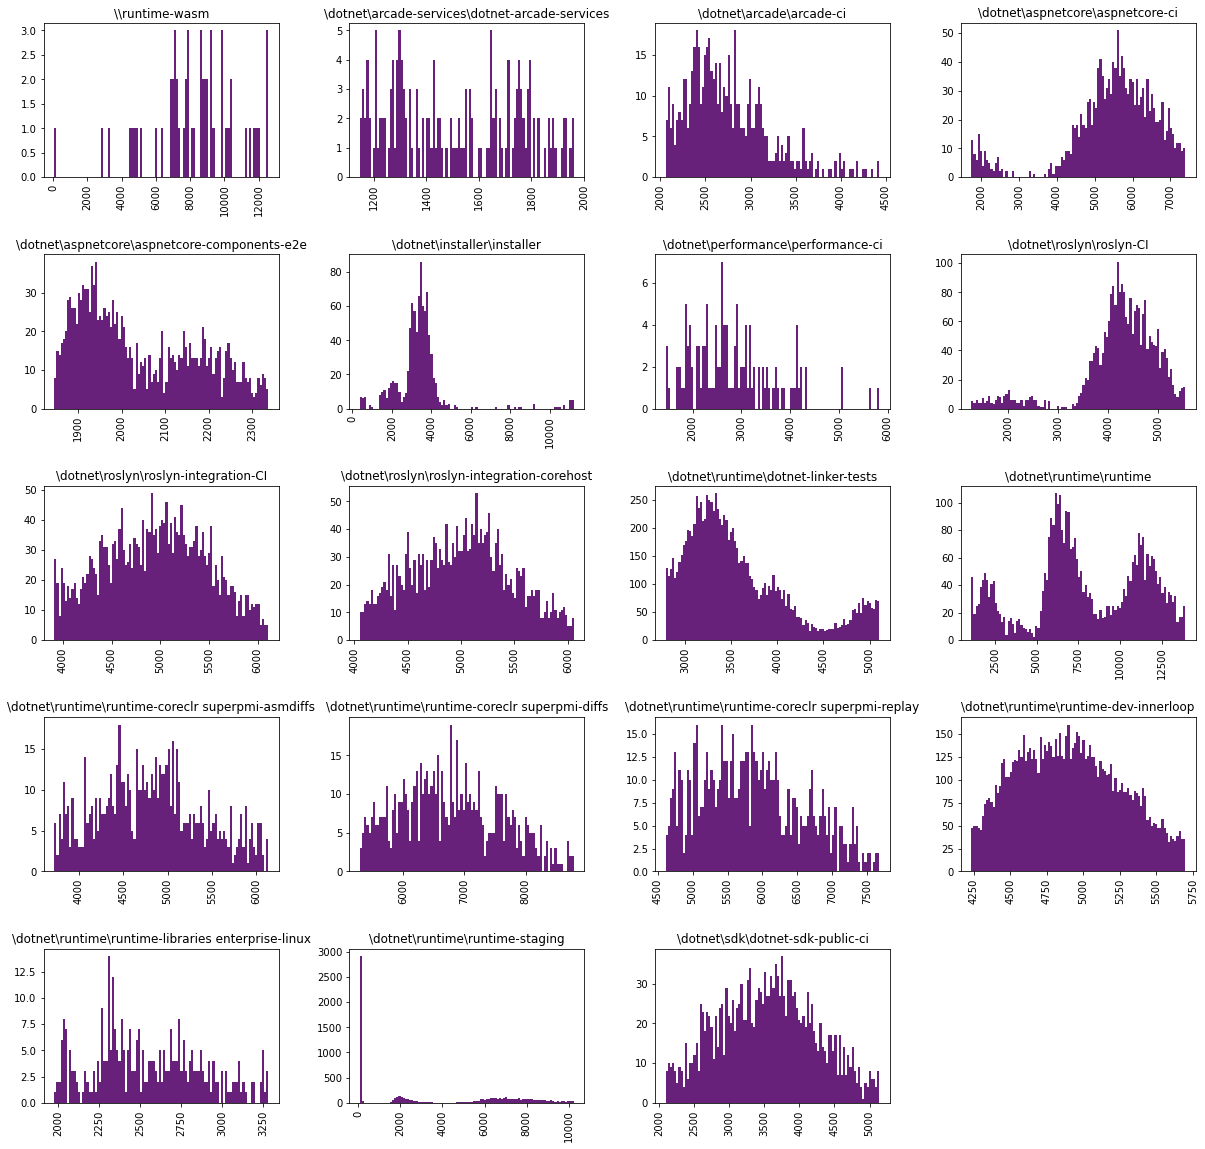

In [522]:
df.PipelineDuration.hist(by=df.Definition, bins=100,figsize=(20,20), color='#68217a')
plt.show()

This is pretty cool. We can see here that while the data is noisy, we can use machine learning to fit a distribution curve over these histograms, and use them to create a confidence interval. So, lets analyze some.

In [523]:
def fit_distribution(df, definition):
    df_subset = df[df.Definition == definition]
    
    dist = distfit()
    dist.fit_transform(df_subset.PipelineDuration.to_numpy(), verbose=1)
    
    return dist

In [524]:
from datetime import timedelta

def pretty_interval(iv):
    center = round((iv[0] + iv[1]) / 2)
    width = round(iv[1] - center)

    center_s = str(timedelta(seconds=center))
    width_s = str(timedelta(seconds=width))
    
    return f"{center_s} ± {width_s}"

In [525]:
def show_model(df, definition):
    dist = fit_distribution(df, definition)
    dist.plot(title=definition.split('\\')[-1])

    print(pretty_interval(dist.model['model'].interval(0.95)))
    print(f"RSS: {dist.model['score']}")

#### Worst Case: \dotnet\runtime\runtime

[distfit] >plot..
2:22:50 ± 1:46:20
RSS: 8.758122531521541e-08


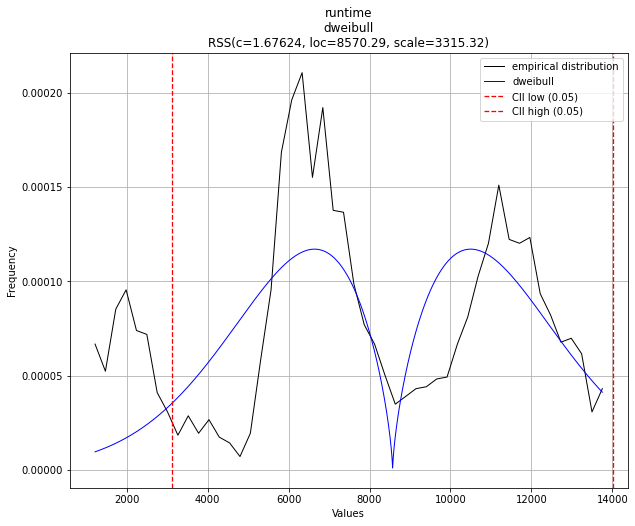

In [526]:
show_model(df, "\\dotnet\\runtime\\runtime")

#### Average Case: \\dotnet\\roslyn\\roslyn-CI

[distfit] >plot..
1:11:41 ± 0:27:56
RSS: 3.9375854105277243e-07


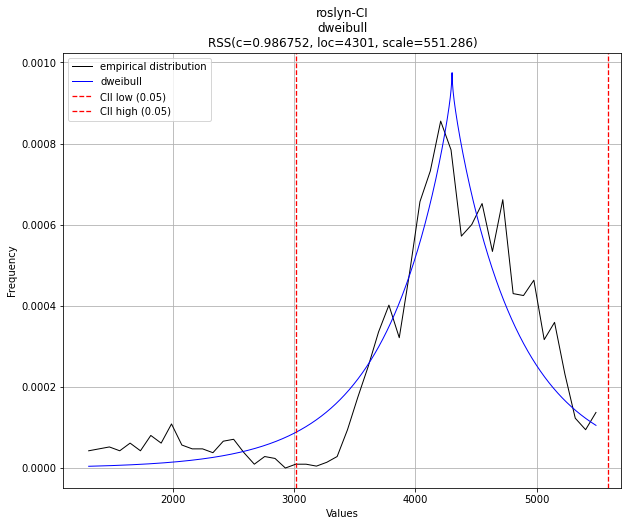

In [527]:
show_model(df, "\\dotnet\\roslyn\\roslyn-CI")

#### Best Case: \\dotnet\\runtime\\runtime-dev-innerloop

[distfit] >plot..
1:22:23 ± 0:10:35
RSS: 2.412955783444402e-07


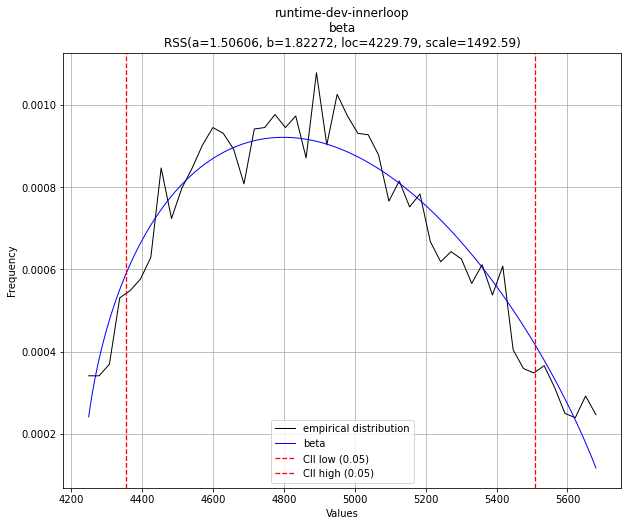

In [528]:
show_model(df, "\\dotnet\\runtime\\runtime-dev-innerloop")

#### Analysis

This model works *well*. Our RSS is very small, indicating a good fit. The main issue with some pipelines, like `\dotnet\runtime\runtime` is that the distribution is multimodal. That runtime pipeline has 3 modes, and this makes sense if you look at the setup of their pipeline. In runtime, their first step is ['evaluate paths'](https://github.com/dotnet/runtime/blob/main/eng/pipelines/common/evaluate-default-paths.yml) that dynamically spits out Azure Pipeline Variables based on what changed in the PR. Then their pipeline runs different steps.

To solve this problem, we'd have to add a custom handler for multimodal distributions to determine extra variables to make them unimodal. In the runtime case, this would mean combing through our data, finding those evaluate path steps, and parsing their job output. Then we could seperate the distributions into different cateogories. There are several issues with this approach. We have to hardcode what we're looking for in their pipeline, do lots of extra work for one specific pipeline (*i.e.* hardcode), and also wait for these steps to complete before showing any estimates. So we have 4 options:

1. Show our customers a wide prediction, and cite the multimodal distribution as why
2. Don't show our customer their prediction as its too wide
3. Lower our confidence interval to get a reasonable estimate
4. Implement *some* solution that can parse the CI timelines and filter the distributions.

### **Question**: Do pipeline durations have a statistically significant difference when seperated by day of the week?

Intuitively, it makes sense if for example on weekends, there is less overall traffic to repos, and thus the duration should be shorter. Since we have the data from the population, we can use a z-test to determine if our results are statistically significant.

$H_a$: The day of the week increases or decreases the pipeline duration.

$H_0$: The day of the week has no effect on the pipeline duration.

If we can reject the null hypothesis, it would be beneficial to build seperate models per day of week for the repos.

We'll start by making a copy of our data to work off of, and extend the day of week on it.

In [529]:
dow_df = df.copy()
dow_df['DayOfWeek'] = dow_df.FinishTime.dt.day_name()
dow_df.head()

,Repository,Definition,SourceBranch,PipelineDuration,FinishTime,DayOfWeek
1,dotnet/runtime,\dotnet\runtime\dotnet-linker-tests,refs/pull/62655/merge,4180,2021-12-14 22:41:21,Tuesday
2,dotnet/roslyn,\dotnet\roslyn\roslyn-integration-corehost,refs/pull/58241/merge,5530,2021-12-14 22:42:25,Tuesday
4,dotnet/sdk,\dotnet\sdk\dotnet-sdk-public-ci,refs/pull/23068/merge,2880,2021-12-14 22:47:16,Tuesday
6,dotnet/runtime,\dotnet\runtime\dotnet-linker-tests,refs/pull/62814/merge,3492,2021-12-14 22:55:53,Tuesday
7,dotnet/installer,\dotnet\installer\installer,refs/pull/12766/merge,3868,2021-12-14 22:56:14,Tuesday


What does the distribution by day look like for `\dotnet\runtime\runtime`?

array([[<AxesSubplot:title={'center':'Friday'}>,
        <AxesSubplot:title={'center':'Monday'}>,
        <AxesSubplot:title={'center':'Saturday'}>],
       [<AxesSubplot:title={'center':'Sunday'}>,
        <AxesSubplot:title={'center':'Thursday'}>,
        <AxesSubplot:title={'center':'Tuesday'}>],
       [<AxesSubplot:title={'center':'Wednesday'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

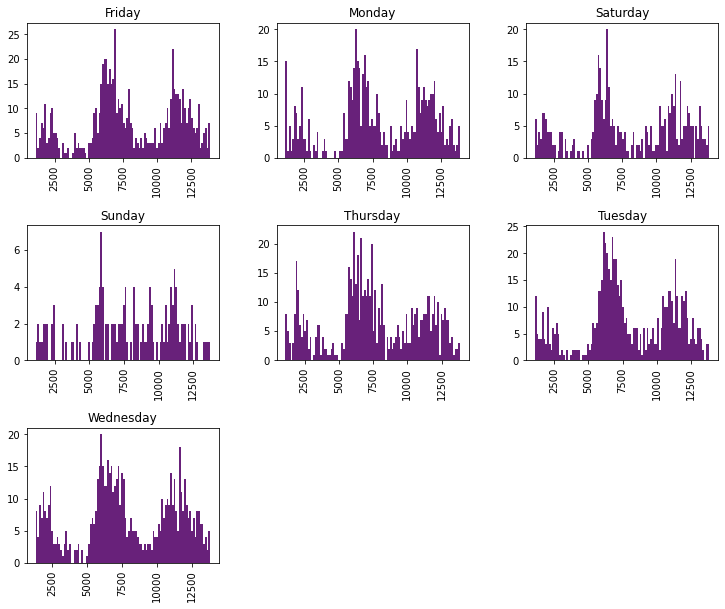

In [530]:
runtime_dow_df = dow_df[dow_df.Definition == "\\dotnet\\runtime\\runtime"]
runtime_dow_df.PipelineDuration.hist(by=runtime_dow_df.DayOfWeek, bins=100,figsize=(12,10), color='#68217a')

It's hard to tell by the graph, but it *looks* like the distributions don't change by the day. Lets do a z-test on all the definitions.

In [531]:
from statsmodels.stats.weightstats import ztest

# the p-value at which we can reject the null hypothesis that the distribution of the pipeline duration is the same for all days of the week.
P_CRIT = 0.05

def compute_ztest(df, definition, day_of_week):
    population = df[df.Definition == definition]
    sample = population[population.DayOfWeek == day_of_week]

    return ztest(population.PipelineDuration, sample.PipelineDuration)

DAYS_OF_WEEK = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
num_significant = 0

for pipeline in dow_df.Definition.unique():
    for day in DAYS_OF_WEEK:
        z, p = compute_ztest(dow_df, pipeline, day)
        if p < P_CRIT:
            num_significant += 1
            print(f"{pipeline:>47}\t{day:>10}\t{p:.3f} ({z:5.2f})")

print(f"Percent Significant: {num_significant / (len(dow_df.Definition.unique()) * len(DAYS_OF_WEEK)) * 100:.1f}%")

            \dotnet\runtime\dotnet-linker-tests	    Monday	0.033 (-2.13)
            \dotnet\runtime\dotnet-linker-tests	   Tuesday	0.005 (-2.80)
            \dotnet\runtime\dotnet-linker-tests	 Wednesday	0.023 (-2.27)
            \dotnet\runtime\dotnet-linker-tests	  Saturday	0.000 ( 5.80)
            \dotnet\runtime\dotnet-linker-tests	    Sunday	0.000 ( 7.78)
     \dotnet\roslyn\roslyn-integration-corehost	    Monday	0.025 ( 2.24)
     \dotnet\roslyn\roslyn-integration-corehost	 Wednesday	0.017 (-2.38)
               \dotnet\sdk\dotnet-sdk-public-ci	    Sunday	0.045 (-2.01)
          \dotnet\runtime\runtime-dev-innerloop	   Tuesday	0.044 (-2.01)
          \dotnet\runtime\runtime-dev-innerloop	 Wednesday	0.000 (-3.77)
          \dotnet\runtime\runtime-dev-innerloop	  Thursday	0.037 (-2.09)
          \dotnet\runtime\runtime-dev-innerloop	  Saturday	0.000 ( 5.39)
          \dotnet\runtime\runtime-dev-innerloop	    Sunday	0.000 ( 9.59)
                \dotnet\runtime\runtime-staging	   

Only $18.8\%$ of the pipeline durations by day are significant. While its nice to know that we aren't wrong only showing a model over every day, lets see if a per-day model can tighten the 95% confidence interval.

In [532]:
import warnings
warnings.filterwarnings("ignore")

In [533]:
def build_model(df):
    dist = distfit()
    dist.fit_transform(df.PipelineDuration.to_numpy(), verbose=1)
    return dist.model['model']

pop_ranges = [build_model(dow_df[dow_df.Definition == x]).interval(0.95) for x in dow_df.Definition.unique()]
day_ranges = [build_model(dow_df[(dow_df.Definition == d) & (dow_df.DayOfWeek == day)]).interval(0.95) for d in dow_df.Definition.unique() for day in DAYS_OF_WEEK]

We'll collapse the intervals into ranges and then display some statistics on them, starting with the regular ranges, then the specific day of week ranges, in seconds.

In [534]:
pop_r_s = pd.Series([x2 - x1 for x1, x2 in pop_ranges])
pop_r_s.describe().apply(lambda x: format(x, 'f'))

count         19.000000
mean       61102.592550
std       251501.348274
min          561.584708
25%         1771.911977
50%         2556.875745
75%         4071.246571
max      1099595.126092
dtype: object

In [535]:
day_r_s = pd.Series([x2 - x1 for x1, x2 in day_ranges])
day_r_s.describe().apply(lambda x: format(x, 'f'))

count        133.000000
mean       94596.858154
std       412440.230520
min            0.020561
25%         1746.790754
50%         2511.670132
75%         4151.841663
max      3185841.879326
dtype: object

#### Analysis

It is not better to create day ranges for specific pipelines. Using the historical data at hand is fine. The median range decreased from 2557 seconds to 2511 seconds, for a $1.8\%$ decrease.

### **Question**: Does this model accurately predict future pipeline durations?

Our previous analysis cheated by having all of the available data at hand. Of course our model would be accurate with all the data at hand. How does this model perform with a small subset of data that then eventually grows and retrains over time?

We're looking for a time series split, where we have an initial training set of data, then test our model by making predictions on future data we haven't trained on. After testing, we add that test data to our training data, retrain the model, and make predictions again on data we have not seen and evaluate our performance. This process repeats, as this diagram shows:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)

Lets update our model every 7 days.

In [536]:
RETRAIN_EVERY = timedelta(days=7)

In [537]:
# find the number of splits such that each split is roughly RETRAIN_EVERY long
num_splits = math.ceil((df.FinishTime.max() - df.FinishTime.min()) / RETRAIN_EVERY)
num_splits

29

In [538]:
def train_models(train_df):
    models = {}
    for definition in train_df.Definition.unique():
        dist = distfit(todf=False)
        dist.fit_transform(train_df[train_df.Definition == definition].PipelineDuration.to_numpy(), verbose=1)

        models[definition] = dist.model['model'].interval(0.95)
        
    return models

In [539]:
def test_models(test_df, models):
    # filter the test_df to only include rows with a definition in the models dict
    test_df = test_df[test_df.Definition.isin(models.keys())]
    results = test_df.apply(lambda x: x.PipelineDuration >= models[x.Definition][0] and x.PipelineDuration <= models[x.Definition][1], axis=1).to_numpy()
    return results

Now, we'll iterate and train our data. Our back-testing works by returning the first $k$ folds as train set and then $(k+1)$ th fold as a test set (where $k=29$ in this case). This is handled for us by the [Time Series Split](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) from scikit-learn.

In [540]:
from sklearn.model_selection import TimeSeriesSplit

model_results = pd.DataFrame(columns=['Time', 'Accuracy'])

tscv = TimeSeriesSplit(n_splits=num_splits)

for train_index, test_index in tqdm(tscv.split(df), total=num_splits):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    models = train_models(train_df)
    results = test_models(test_df, models)

    accuracy = results.mean()

    # add to model_results
    model_results.loc[len(model_results)] = [train_df.FinishTime.max(), accuracy]


  0%|          | 0/29 [00:00<?, ?it/s]

What does the accuracy over time look like? It should be *slightly* less than 95% as there will be some hiccups in Helix and AzDo.

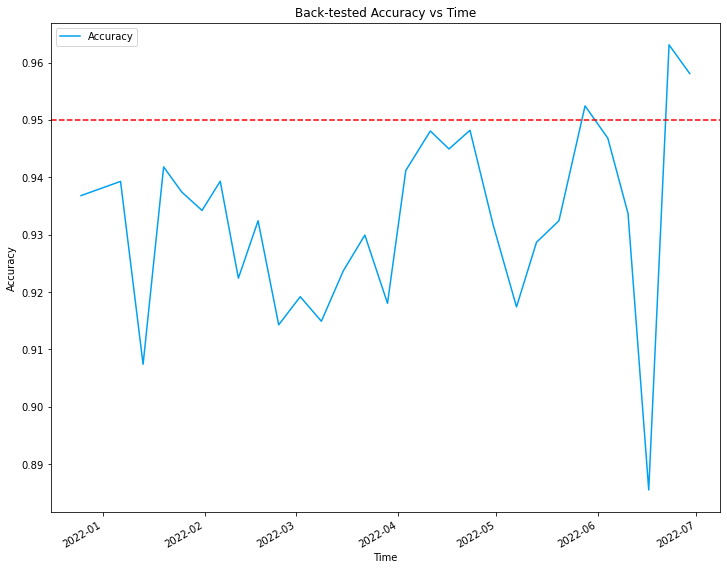

In [541]:
# plot the accuracy
ax = model_results.plot.line(x='Time', y='Accuracy', figsize=(12,10), ylabel='Accuracy', color='#00a1f1',title="Back-tested Accuracy vs Time")

# add a red line y=0.95
ax.axhline(y=0.95, color='red', linestyle='--')
plt.show()

Not too bad. We hover around 93% accurate, with a dip slightly below 89% for a week. What are the detailed statistics for the accuracy?

In [542]:
model_results.Accuracy.apply(lambda x: x * 100).describe()

count    29.000000
mean     93.252058
std       1.629674
min      88.548185
25%      92.240300
50%      93.366708
75%      94.180225
max      96.307885
Name: Accuracy, dtype: float64

#### Analysis

We have a fairly accuate model. At its worst, over all of our previous data, we were only $88.5\%$ accurate, with an average of being $93.3\%$ accurate. This works most of the time, but there still lies the issue of what happens when Helix is completely on the floor? Giving an estimate when something is wrong is not goood.

### **Question**: Can we use ML to detect anomalies in Helix and not show our customers predictions to increase our accuracy?

One of the obvious signs of health in Helix are the work item wait times. We can develop an unsupervised anomaly detection model to determine when Helix is unhealthy, and hide our predictions in this case. To build this model we'll query Kusto for the work item wait time for all queues, and take the 95th percentile.

Again, I've done the liberty of uploading this data as a gist for reproducability. Load the data.

In [543]:
wait_df = pd.read_csv("https://gist.githubusercontent.com/melotic/c6cd7339a70553700aef23d5d7b768a1/raw/32009fddb29d869b2ddb4bc9700f22ace39ab4c3/workitem_wait_times.csv")
wait_df

,Started,Percentile95
0,2022-03-09 21:00:00.0000000,5
1,2022-03-09 21:05:00.0000000,7
2,2022-03-09 21:25:00.0000000,27
3,2022-03-09 21:30:00.0000000,9
4,2022-03-09 21:35:00.0000000,17
...,...,...
34024,2022-07-06 18:15:00.0000000,24
34025,2022-07-06 18:20:00.0000000,27
34026,2022-07-06 18:25:00.0000000,28
34027,2022-07-06 18:30:00.0000000,31


Lets also ensure that the `Started` column is a datetime.

In [544]:
wait_df.dtypes

Started         object
Percentile95     int64
dtype: object

In [545]:
wait_df.Started = pd.to_datetime(wait_df.Started)
wait_df.head()

,Started,Percentile95
0,2022-03-09 21:00:00,5
1,2022-03-09 21:05:00,7
2,2022-03-09 21:25:00,27
3,2022-03-09 21:30:00,9
4,2022-03-09 21:35:00,17


We only want to detect outliars that are above the normal, not below it. So lets filter our data to remove entries that are less 20 minutes.

In [546]:
# we dont care about short waits
wait_df = wait_df[wait_df.Percentile95 > 20]

Lets plot this in a line graph and see what the data looks like over time.

<AxesSubplot:title={'center':'Wait Time vs Time'}, xlabel='Started', ylabel='WaitTime'>

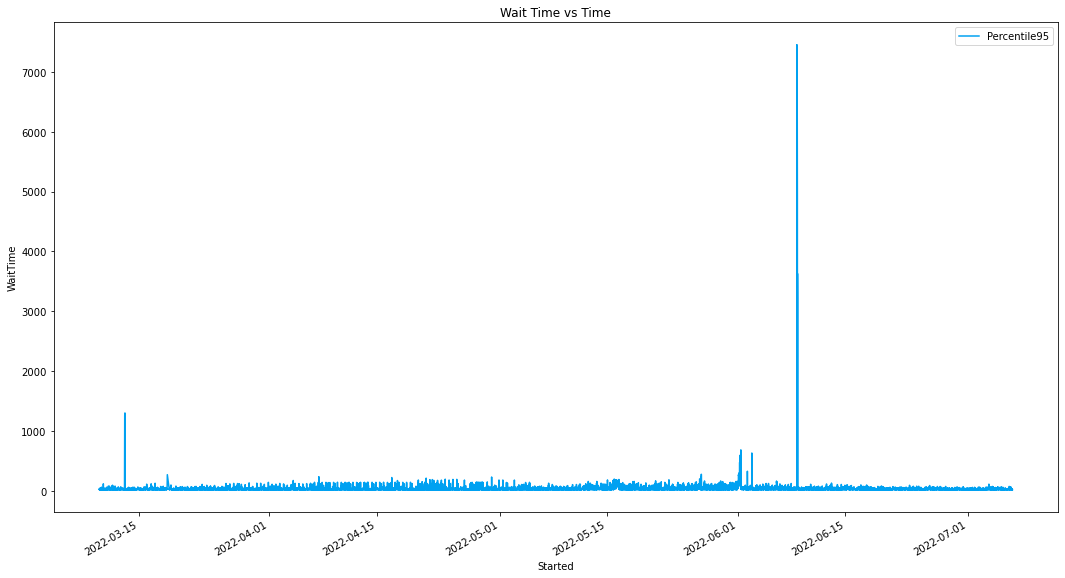

In [547]:
wait_df.plot.line(x='Started', y='Percentile95', figsize=(18,10), ylabel='WaitTime', color='#00a1f1',title="Wait Time vs Time")

There are some clear anomalies. Lets build an Isolation Forest and see if we can detect them. We'll set our contamation rate, the percentage of our data that are *likely* outliars. This is a hyperparameter that can be tuned.

In [548]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.15).fit(wait_df.Percentile95.to_numpy().reshape(-1, 1))

# add scores to the dataframe
wait_df['AnomalyScore'] = clf.predict(wait_df.Percentile95.to_numpy().reshape(-1, 1))
wait_df

,Started,Percentile95,AnomalyScore
2,2022-03-09 21:25:00,27,1
5,2022-03-09 21:40:00,44,1
6,2022-03-09 21:45:00,21,-1
7,2022-03-09 21:50:00,23,1
8,2022-03-09 21:55:00,24,1
...,...,...,...
34024,2022-07-06 18:15:00,24,1
34025,2022-07-06 18:20:00,27,1
34026,2022-07-06 18:25:00,28,1
34027,2022-07-06 18:30:00,31,1


We should ensure that the data marked anomalous is actually looking anomalous.

In [549]:
wait_df[wait_df.AnomalyScore == -1].describe()

,Percentile95,AnomalyScore
count,4333.000000,4333.0
mean,101.758135,-1.0
std,360.166713,0.0
min,21.000000,-1.0
25%,21.000000,-1.0
50%,70.000000,-1.0
75%,100.000000,-1.0
max,7454.000000,-1.0


This looks good. We also should include an "Anomaly" rate. We don't care that one work item's wait time is high, we care about a **pattern** of anomalies. We'll compute this by averaging the last 30min anomaly scores, to generate a number between $[-1,1]$, with $-1$ meaning anomalous.

In [550]:
# add an 'AnomalyRate' column to the dataframe over the last 30 min
wait_df['AnomalyRate'] = wait_df.AnomalyScore.rolling(30//5).mean()
wait_df.dropna(inplace=True)
wait_df

,Started,Percentile95,AnomalyScore,AnomalyRate
9,2022-03-09 22:00:00,26,1,0.666667
10,2022-03-09 22:05:00,26,1,0.666667
11,2022-03-09 22:10:00,21,-1,0.333333
12,2022-03-09 22:15:00,34,1,0.666667
13,2022-03-09 22:20:00,34,1,0.666667
...,...,...,...,...
34024,2022-07-06 18:15:00,24,1,1.000000
34025,2022-07-06 18:20:00,27,1,1.000000
34026,2022-07-06 18:25:00,28,1,1.000000
34027,2022-07-06 18:30:00,31,1,1.000000


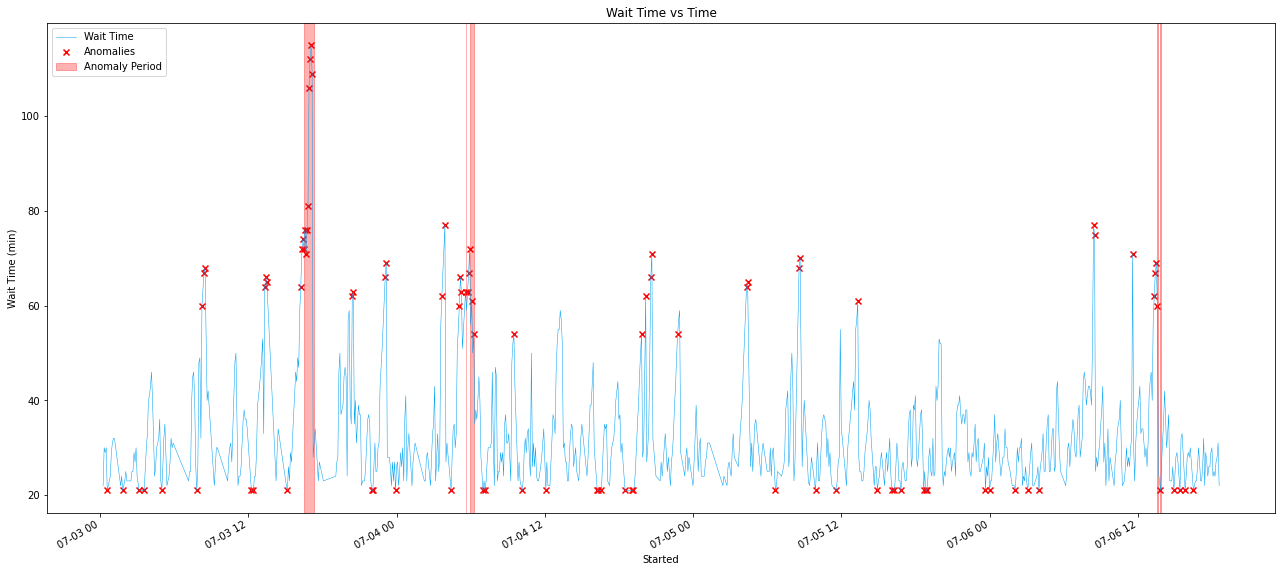

In [551]:
# plot only a week of data
p_wait_df = wait_df[(wait_df.Started > '2022-07-03') ]

ax = p_wait_df.plot.line(x='Started', y='Percentile95', ylabel='Wait Time (min)', color='#00a1f1',title="Wait Time vs Time", lw=0.5, figsize=(22,10))

# plot red x's for anomalies
anoms = p_wait_df[p_wait_df.AnomalyScore == -1]
ax.scatter(anoms.Started, anoms.Percentile95, color='red', marker='x')

# shade when  the anomalous rate is less than 0
anom_periods = p_wait_df[p_wait_df.AnomalyRate < 0]

# clever trick to groupby sequential indexes when the anomaly rate is consistently negative
list_of_seqs = [d for _, d in anom_periods.groupby(anom_periods.index - np.arange(len(anom_periods)))]

for seq in list_of_seqs:
    ax.axvspan(seq.Started.min(), seq.Started.max(), color='red', alpha=0.3)

ax.legend(['Wait Time', 'Anomalies', 'Anomaly Period'])
plt.show()

This does a decent job filtering out long periods of anamlous wait times, that we should maybe see if can help improve our accuracy. The red shaded area is where we would hide our predictions. Let's retest our model again, ignoring periods of anomaly. First, we'll have to add a `Started` column to our original data, as our kusto query didn't capture this.

In [552]:
df['Started'] = df.FinishTime - df.PipelineDuration.apply(lambda x: timedelta(seconds=x))
df.head()

,Repository,Definition,SourceBranch,PipelineDuration,FinishTime,Started
1,dotnet/runtime,\dotnet\runtime\dotnet-linker-tests,refs/pull/62655/merge,4180,2021-12-14 22:41:21,2021-12-14 21:31:41
2,dotnet/roslyn,\dotnet\roslyn\roslyn-integration-corehost,refs/pull/58241/merge,5530,2021-12-14 22:42:25,2021-12-14 21:10:15
4,dotnet/sdk,\dotnet\sdk\dotnet-sdk-public-ci,refs/pull/23068/merge,2880,2021-12-14 22:47:16,2021-12-14 21:59:16
6,dotnet/runtime,\dotnet\runtime\dotnet-linker-tests,refs/pull/62814/merge,3492,2021-12-14 22:55:53,2021-12-14 21:57:41
7,dotnet/installer,\dotnet\installer\installer,refs/pull/12766/merge,3868,2021-12-14 22:56:14,2021-12-14 21:51:46


In [553]:
# remove all data whose anomly rate is >= 0
anomaly_df = wait_df[wait_df.AnomalyRate < 0]
anomaly_df.head()

,Started,Percentile95,AnomalyScore,AnomalyRate
483,2022-03-11 13:45:00,91,-1,-0.333333
484,2022-03-11 13:50:00,93,-1,-0.666667
485,2022-03-11 13:55:00,55,1,-0.666667
486,2022-03-11 14:00:00,57,1,-0.333333
487,2022-03-11 14:05:00,63,-1,-0.333333


In [554]:
wait_df.Started.min()

Timestamp('2022-03-09 22:00:00')

In [555]:
def test_models(test_df, models, anomaly_df):
    # filter the test_df to only include rows with a definition in the models dict
    test_df = test_df[test_df.Definition.isin(models.keys())]

    # we only want test_df data where the started time, floored to the nearest 5 minutes, is not in the anomaly_df
    test_df = test_df[~test_df.Started.apply(lambda x: x.floor(freq='5min')).isin(anomaly_df.Started)]

    results = test_df.apply(lambda x: x.PipelineDuration >= models[x.Definition][0] and x.PipelineDuration <= models[x.Definition][1], axis=1).to_numpy()
    return results

In [556]:
model_results_a = pd.DataFrame(columns=['Time', 'Accuracy'])
tscv = TimeSeriesSplit(n_splits=num_splits)

anomaly_data_start = wait_df.Started.min()

for train_index, test_index in tqdm(tscv.split(df), total=num_splits):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    # don't process data before the anomaly data start
    if test_df.Started.min() < anomaly_data_start:
        continue

    models = train_models(train_df)
    results = test_models(test_df, models, anomaly_df)

    accuracy = results.mean()

    # add to model_results_a
    model_results_a.loc[len(model_results_a)] = [train_df.FinishTime.max(), accuracy]


  0%|          | 0/29 [00:00<?, ?it/s]

In [557]:
model_results.tail()

,Time,Accuracy
24,2022-06-03 23:46:46,0.946809
25,2022-06-10 03:46:36,0.933667
26,2022-06-16 11:18:06,0.885482
27,2022-06-22 16:04:22,0.963079
28,2022-06-28 23:30:27,0.958073


In [558]:
model_results_a.tail()

,Time,Accuracy
12,2022-06-03 23:46:46,0.946959
13,2022-06-10 03:46:36,0.931968
14,2022-06-16 11:18:06,0.884640
15,2022-06-22 16:04:22,0.962776
16,2022-06-28 23:30:27,0.957941


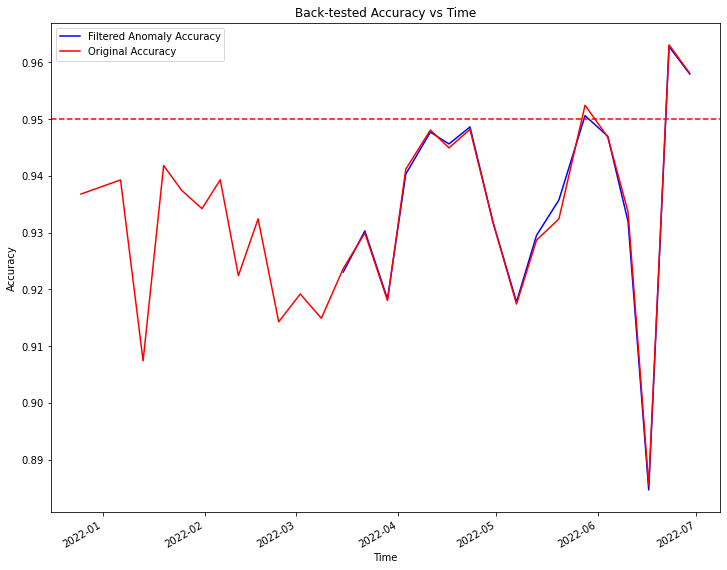

In [559]:
# plot the accuracy
ax = model_results_a.plot.line(x='Time', y='Accuracy', figsize=(12,10), ylabel='Accuracy', label='Filtered Anomaly Accuracy', color='blue',title="Back-tested Accuracy vs Time")
model_results.plot(x='Time', y='Accuracy', figsize=(12,10), color='red', label='Original Accuracy', ax=ax)
# add a red line y=0.95
ax.axhline(y=0.95, color='red', linestyle='--')
plt.show()

In [560]:
model_results[model_results.Time >= model_results_a.Time.min()].Accuracy.apply(lambda x: x * 100).describe()

count    17.000000
mean     93.551506
std       1.854859
min      88.548185
25%      92.866083
50%      93.366708
75%      94.806008
max      96.307885
Name: Accuracy, dtype: float64

In [561]:
model_results_a.Accuracy.apply(lambda x: x * 100).describe()

count    17.000000
mean     93.550460
std       1.853399
min      88.464031
25%      92.949757
50%      93.575419
75%      94.770006
max      96.277603
Name: Accuracy, dtype: float64

#### Analysis

Clearly, our approach here is wrong. This could be because pipelines are more variable than just Helix itself, or that work item wait times are not a good sign of anomaly in Helix. We need another solution to determine whether AzDo & Helix are on the floor to be able to hide predictions when things are not looking good.

## Next Steps

The data analysis here shows that regressing a distribution and spitting out confidence intervals is an effective technique in predicting the length of the pipeline. We still have two problems for this PoC:

1. We need to hide/update our predictions when AzDo or Helix is on the floor.
2. We need to decompose piplines that have a multimodal distribution.

### Implementation

We can implmenet the machine learning functionality as a Azure Function that we can call directly from Queue Insights. This enables us to reuse the code featured in this one-pager in production, in python. We'll have a pipeline that can retrain our dataset every week.


## Risk

* Will the new implementation of any existing functionality cause breaking changes for existing consumers?
  * No, this will be a new feature.
* What are your assumptions?
  * We'll constantly maintain data in the `TimelineBuilds` table. This feature depends on it.
* What are your unknowns?
  * See above, how do we decompose multimodal distributions and become notified when services are down?
* What dependencies will this epic/feature(s) have?
  * `TimelineBuilds`
  * Python machine learning libraries (python, skikit-learn, distfit, pandas..)
  * Azure Functions
* Are the dependencies currently in a state that the functionality in the epic can consume them now, or will they need to be updated?
  * We can consume them now.
* Is there a goal to have this work completed by, and what is the risk of not hitting that date? (e.g. missed OKRs, increased pain-points for consumers, functionality is required for the next product release, et cetera)
  * Aug 12, the end of the internship.
* Does anything the new feature depend on consume a limited/throttled API resource?
  * No. Kusto will be queried once a week to retrain the models.
* Have you estimated what maximum usage is?
  * No, but it wil be the same as the Queue Insights project.
* Are you utilizing any response data that allows intelligent back-off from the service?
  * We only query Kusto, so there is no need for back-off.
* What is the plan for getting more capacity if the feature both must exist and needs more capacity than available?
  * Azure Functions should auto-scale our function if our ML endpoint is being queried hard.